In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from numba import jit
import opt_einsum
from numba import jit
import scipy
import torch

In [2]:
class GRF:
    def __init__(self, N_samples, d, l):
        super().__init__()
        self.N_samples = N_samples
        self.d = d
        self.l = l
        self.n_samples_per_l = 10
        self.mus = self.compute_mus()
        self.f_hat = self.compute_RBFintcoeffs()
        self.i = 0
        
    def compute_mus(self):
        mus = np.random.uniform(0,1,size=(int(np.ceil(self.n_samples_per_l/self.l**self.d)), self.d))
        return mus
       
    def compute_cov(self):
        cov = np.exp(-distance_matrix(self.mus, self.mus, p=2)**2/(2*self.l**2))
        return cov
    
    def compute_GRFpoints(self, cov):
        f = np.random.multivariate_normal(np.zeros(int(np.ceil(1/self.l**self.d))), cov=cov, size=self.N_samples)
        return f
    
    def compute_RBFintcoeffs(self):
        cov = self.compute_cov()
        cov_inv = np.linalg.inv(cov)
        f = self.compute_GRFpoints(cov)
        f_hat = opt_einsum.contract('ij,nj->ni', cov_inv, f)
        return f_hat
    
    def phi_n(self, i, x):
        phi_n = self.f_hat[i,None,:]*np.exp(-np.sum((x[:,None,:] - self.mus[None,:,:])**2, axis=-1)/(2*self.l**2))
        return phi_n
    
    def forward(self, i):
        def function(x):
            phi_n = self.phi_n(i, x)
            return np.sum(phi_n, axis=1)
        return function
    
    def grad(self, i):
        def function(x):
            phi_n = self.phi_n(i, x)
            prefactor = -1/(self.l**2)*(x[:,None,:] - self.mus[None,:,:])
            return np.sum(prefactor*phi_n[:,:,None], axis=1)
        return function

    def laplacian(self, i):
        def function(x):
            phi_n = self.phi_n(i, x)
            prefactor = (1/self.l**2)*(np.sum((x[:,None,:] - self.mus[None,:,:])**2, axis=-1)/self.l**2 - self.d)
            return np.sum(prefactor*phi_n, axis=1)
        return function
        

class ScaledGRF:
    def __init__(self, N_samples, d, l, c, b):
        super().__init__()
        self.grf = GRF(N_samples, d, l)
        self.c = c
        self.b = b
    
    def forward(self, i):
        def function(x):
            return self.c[i]*self.grf.forward(i)(x) + self.b[i]
        return function
    
    def grad(self, i):
        def function(x):
            return self.c[i]*self.grf.grad(i)(x)
        return function
    
    def laplacian(self, i):
        def function(x):
            return self.c[i]*self.grf.laplacian(i)(x)
        return function

In [106]:
import matplotlib.pyplot as plt

In [6]:
np.pi*0.5**2

0.7853981633974483

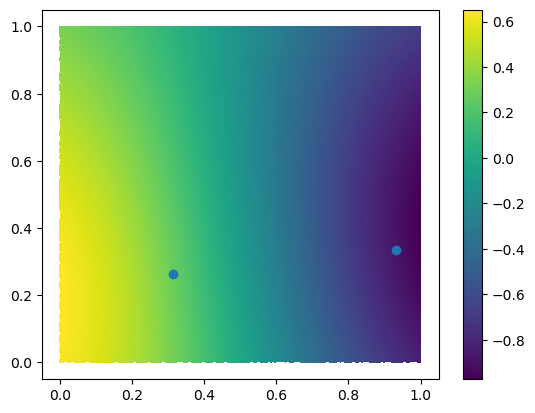

In [107]:
i=5
func = grf.forward(i)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i))
plt.colorbar()
plt.scatter(grf.mus[:,0],grf.mus[:,1])
# plt.scatter(grf.x_grid[:,0], grf.x_grid[:,1], color='black')
# plt.savefig("GRF.svg", bbox_inches='tight', transparent=True)